In [1]:
import json
import requests
import praw
import os
from dotenv import load_dotenv
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt

df = pd.read_csv('reviews_added.csv')
df.drop(columns = 'Unnamed: 0', inplace=True)
df

,timestamp,name,username,link,rating,region,price,date,review
0,12/14/2012 10:03:18,100 Pipers,merlinblack,http://www.reddit.com/r/Scotch/comments/14uder...,68,Blend,NaN,12/14/12,My wife and I are on a trip to Thailand to mee...
1,10/26/2019 17:19:55,1792 12 Year,atxbourbon,https://www.reddit.com/r/bourbon/comments/dgyb...,70,Bourbon,50,10/12/19,I'm still a fan of 1792 even though my initial...
2,NaN,1792 12 Year,LIFOanAccountant,https://www.reddit.com/r/bourbon/comments/pazy...,82,Bourbon,NaN,08/24/21,I'm not a fan of any 1792 I've had. Heat alway...
3,NaN,1792 12 Year,MountainLoon,https://www.reddit.com/r/bourbon/comments/rqo3...,76,Bourbon,70,12/28/21,**Background:** \nOver the holidays I was abl...
4,NaN,1792 12 Year,quixotic-88,https://www.reddit.com/r/bourbon/comments/sed5...,90,Bourbon,45,12/27/22,"I don’t know what it is, but the bottle design..."
...,...,...,...,...,...,...,...,...,...
41350,NaN,Impex Collection 40 1980,b1uepenguin,https://www.reddit.com/r/Scotch/comments/t1btp...,85,Blend,NaN,02/25/22,*Scotch Review #545\tWhisky Network Review #63...
41351,NaN,Milk & Honey Apex Dead Sea,the_muskox,https://www.reddit.com/r/worldwhisky/comments/...,84,Israel,NaN,02/26/22,"Shalom, r/WorldWhisky! Thank you to my buddy A..."
41352,NaN,Linkwood 17 1999 Alexander Murray & Co.,b1uepenguin,https://www.reddit.com/r/Scotch/comments/t25u1...,80,Speyside,NaN,02/26/22,*Scotch Review #546\tWhisky Network Review #63...
41353,NaN,Jura 14 2007 First Editions,the_muskox,https://www.reddit.com/r/Scotch/comments/t2oz1...,68,Islands,$145 CAD,02/27/22,"Howdy, Scotchit!\n\nThis is another dram from ..."


In [5]:
df_copy = df.copy()

# Dropping nulls for the moment (I will try downloading submissions in a bit to see if that picks up any of these)
df_copy = df_copy[~df_copy['review'].isnull()]

# Calculating review length in characters 
df_copy['reviewlength'] = df_copy['review'].apply(lambda x: len(x))

# Selecting only those with at least 500 characters as those are likely to be actual reviews
df_copy = df_copy[df_copy['reviewlength']>500]

missing = list(set(np.arange(0, 41355)) - set(df_copy.index.tolist()))
print(missing)

[24576, 8193, 2, 8194, 4, 16389, 32772, 7, 32776, 32777, 16394, 11, 32780, 13, 14, 24589, 16, 40968, 40969, 19, 20, 21, 22, 24597, 16408, 24598, 16410, 24601, 24604, 40985, 24606, 31, 32, 40993, 40994, 40995, 40996, 8230, 32806, 40, 32807, 32810, 24619, 41001, 45, 24621, 41004, 41006, 32817, 50, 52, 8244, 16436, 56, 16440, 8250, 16442, 8252, 61, 8254, 24636, 24640, 32827, 16450, 24643, 32830, 32831, 70, 16455, 24647, 32838, 32839, 32841, 16460, 24652, 32843, 32844, 32846, 16465, 32848, 83, 24664, 41053, 97, 98, 24675, 39097, 32869, 102, 41062, 16488, 105, 24681, 107, 32872, 109, 32875, 32876, 24688, 32877, 114, 115, 116, 32879, 32886, 41079, 24697, 41082, 123, 41083, 41087, 128, 129, 8321, 24707, 32900, 32904, 32905, 138, 24714, 24715, 24716, 8334, 8335, 144, 32906, 24722, 147, 16531, 24724, 24726, 32910, 32914, 32917, 32918, 24731, 32924, 32925, 158, 8351, 24736, 32926, 162, 24739, 32928, 32930, 32934, 167, 32936, 24745, 173, 32941, 8367, 24751, 24753, 32942, 24755, 24756, 8373, 41141

In [49]:
dfslice = dfslice[~dfslice['review'].isnull()]
dfslice.shape

(14878, 9)

In [50]:
dfslice['reviewlength'] = dfslice['review'].apply(lambda x: len(x))

In [51]:
dfslice.shape

(14878, 10)

(array([1910., 3649., 3020., 1939., 1462.,  945.,  492.,  375.,  243.,
         191.,  174.,  123.,   96.,   96.,   79.,   84.]),
 array([1.00000e+00, 6.26750e+02, 1.25250e+03, 1.87825e+03, 2.50400e+03,
        3.12975e+03, 3.75550e+03, 4.38125e+03, 5.00700e+03, 5.63275e+03,
        6.25850e+03, 6.88425e+03, 7.51000e+03, 8.13575e+03, 8.76150e+03,
        9.38725e+03, 1.00130e+04]),
 <BarContainer object of 16 artists>)

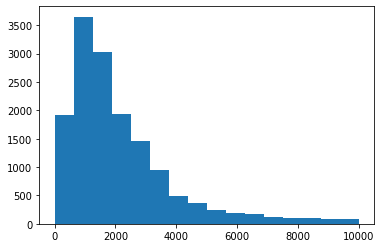

In [52]:
plt.hist(dfslice['reviewlength'], bins=16)

Any comment under 300 characters tends not to be a review. There are some exceptions, but I can deal with a few exceptions. I will probably end up having to look through the full dataset manually anyway.

In [57]:
dfslice[dfslice['reviewlength']>300]['review'].tolist()

["My wife and I are on a trip to Thailand to meet her family.  I've seen plenty of whisky here, mostly JW, but this one stood out from the rest.  100 pipers is not something I've seen before and it seems to have quite the following here.  It is a blend at 40% alcohol by volume and 35cl was 220 baht or about $8 Canadian.  I got it more as a novelty as I suspect it is the Thai equivalent of chivas or glenfiddich 12.\n\nColour: caramel, I suspect it is artificially coloured.\n\nNose: (I had some tiger balm on my hands so this may be *way* off) alcohol, little bit of leather and some hints of sweetness.\n\nPalate: very bland, I taste almost nothing really, a bit of woody flavour, the promise of leather and sweetness from the nose is gone.\n\nFinish: short and devoid of anything but alcohol.\n\nThis reminds me of a JW red or the cheap rye my Dad drank when I was a kid.  I bought it primarily for the novelty so I don't think it was a waste.  it is just not something I'd seek out again.\n\n68